In [1]:
import warnings
import itertools
from collections import namedtuple

In [2]:
import pandas as pd
import numpy as np

In [63]:
import statsmodels.api as sm
import statsmodels

In [4]:
import matplotlib.pyplot as plt

In [105]:
data = pd.read_csv("hurricanes_augmented.csv", dtype={"Date_string": np.object_, "Time_string": np.object_})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280 entries, 0 to 5279
Data columns (total 16 columns):
id                 5280 non-null object
Name               5280 non-null object
Date_string        5280 non-null object
Time_string        5280 non-null object
Event              5280 non-null object
Status             5280 non-null object
Latitude           5280 non-null float64
Longitude          5278 non-null float64
MaxiumWind         5280 non-null int64
MinimumPressure    5280 non-null int64
Date               5280 non-null object
sst                4937 non-null float64
Lat                5280 non-null int64
Long               5280 non-null int64
oni_score          5280 non-null float64
oni_flag           5280 non-null int64
dtypes: float64(4), int64(5), object(7)
memory usage: 660.1+ KB


In [106]:
data["Time_string"] = data["Time_string"].str.pad(width=4, fillchar='0')
data["timestamp"] = pd.to_datetime(data["Date_string"] + " " + data["Time_string"], format="%Y%m%d %H")

In [107]:
data["Name"] = data["Name"].str.strip()

In [108]:
data = data[["id", "Name", "timestamp", "Status", "Latitude", "Longitude", "MaxiumWind", "MinimumPressure", "sst", "oni_flag"]]

In [109]:
data.columns = ["id", "name", "timestamp", "status", "latitude", "longitude", "wind_kt", "min_pressure_mbar", "sea_temp_degc", "oni_flag"]

In [110]:
# NHC makes regular observations *plus* observations at landfall. Let's get only the regular observations.
data = data[data.timestamp.dt.hour.isin([0, 6, 12, 18])]

In [111]:
data.head()

,id,name,timestamp,status,latitude,longitude,wind_kt,min_pressure_mbar,sea_temp_degc,oni_flag
0,AL012007,ANDREA,2007-05-06 12:00:00,EX,35.5,-74.0,35,1012,22.991250,0
1,AL012007,ANDREA,2007-05-06 18:00:00,EX,35.0,-73.0,40,1009,21.806250,0
2,AL012007,ANDREA,2007-05-07 00:00:00,EX,34.3,-71.7,50,1005,21.414999,0
3,AL012007,ANDREA,2007-05-07 06:00:00,EX,33.3,-72.3,65,998,20.699999,0
4,AL012007,ANDREA,2007-05-07 12:00:00,EX,32.3,-73.1,65,998,20.180624,0


In [11]:
# next steps:
# do this as a big pandas groupby
# for key, group in data.groupby("id"):
#     print(key)
#     hurricane = group.copy()
    
#     # There are other observations that don't occur on a regular schedule. Ignore any tropical event with those observations.
#     try:
#         date_index = pd.DatetimeIndex(hurricane["timestamp"], freq="6H")
#     except ValueError as e:
#         print(e)
#         continue # Reminder: "continue" means skip everything else and go to the next item in the loop
#     hurricane = hurricane.set_index(date_index)
    
    
#     max_seasonality_frequency = 10
    
#     # Ignore hurricanes that do not have at least 10 observations
#     if hurricane.shape[0] <= max_seasonality_frequency:
#         continue
#     decomposition = sm.tsa.seasonal_decompose(hurricane[['min_pressure_mbar']], freq=max_seasonality_frequency)
#     ax = decomposition.plot()
#     plt.show()

In [97]:
# I am using machine learning to get the best model for the new prediction target

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2 + 1)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 0, 2, 7)
SARIMAX: (0, 0, 2) x (0, 1, 0, 7)
SARIMAX: (0, 0, 2) x (0, 1, 1, 7)


In [98]:
ModelSelectionResults = namedtuple('ModelSelectionResults', ["order", "seasonal_order", "aic"])

## Model Selection  
(Warning! Takes forever if your order > 1. Just skip this section)

In [ ]:
best_models = []

for key, group in data.groupby("id"):
    print(key)
    hurricane = group.copy()
    
    # There are other observations that don't occur on a regular schedule. Ignore any tropical event with those observations.
    try:
        date_index = pd.DatetimeIndex(hurricane["timestamp"], freq="6H")
    except ValueError as e:
        print(e)
        continue # Reminder: "continue" means skip everything else and go to the next item in the loop
    hurricane = hurricane.set_index(date_index)
    
    
    max_seasonality_frequency = 10
    
    # Ignore hurricanes that do not have at least 10 observations
    if hurricane.shape[0] <= max_seasonality_frequency:
        print("too short!")
        continue
    
    models = []
    maxlag_errors = 0
    non_positive_definite_covariance_matrix_errors = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    mod = sm.tsa.statespace.SARIMAX(hurricane['min_pressure_mbar'],
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)

                    results = mod.fit()
                models.append(ModelSelectionResults(order=param, seasonal_order=param_seasonal, aic=results.aic))
            except ValueError as e:
                if str(e) == "maxlag should be < nobs":
                    maxlag_errors += 1
                else:
                    print("ValueError:", e)
                continue
            except np.linalg.linalg.LinAlgError as e:
                if str(e)[:54] == "Non-positive-definite forecast error covariance matrix":
                    non_positive_definite_covariance_matrix_errors += 1
                else:
                    print("LinAlgError:", e)
                continue
            except IndexError as e:
                continue
    best_model = min(models, default=None, key=lambda x: x.aic)
    
    print("Best Model:", best_model)
    
    if maxlag_errors > 0:
        print(maxlag_errors, "maxlag errors")
    if non_positive_definite_covariance_matrix_errors > 0:
        print(non_positive_definite_covariance_matrix_errors, "linalg errors")
    
    if best_model:
        best_models.append(best_model)

AL012007
Best Model: ModelSelectionResults(order=(0, 2, 0), seasonal_order=(2, 2, 0, 7), aic=-12.72047050346793)
324 maxlag errors
AL012008
too short!
AL012009
Best Model: ModelSelectionResults(order=(0, 0, 0), seasonal_order=(2, 0, 0, 7), aic=-50.772780461745946)
550 maxlag errors
1 linalg errors
AL012010
Best Model: ModelSelectionResults(order=(0, 0, 1), seasonal_order=(2, 2, 0, 7), aic=-14.846018565797745)
360 maxlag errors
AL012011
Best Model: ModelSelectionResults(order=(2, 1, 0), seasonal_order=(1, 0, 0, 7), aic=-29.142776338228217)
657 maxlag errors
AL012012
Best Model: ModelSelectionResults(order=(2, 1, 0), seasonal_order=(2, 0, 0, 7), aic=-41.69059970240963)
576 maxlag errors
AL012013
Best Model: ModelSelectionResults(order=(2, 1, 0), seasonal_order=(1, 0, 0, 7), aic=-39.3685581784753)
654 maxlag errors
AL012014
Best Model: ModelSelectionResults(order=(2, 2, 2), seasonal_order=(2, 2, 1, 7), aic=65.97997126890908)
162 maxlag errors
AL012015
Best Model: ModelSelectionResults(ord

In [103]:
pd.DataFrame([x.order + x.seasonal_order for x in best_models]).mean()

0    1.346667
1    1.140000
2    0.773333
3    1.660000
4    1.180000
5    0.293333
6    7.000000
dtype: float64

In [104]:
pd.DataFrame([x.order + x.seasonal_order for x in best_models]).mean().round()

0    1.0
1    1.0
2    1.0
3    2.0
4    1.0
5    0.0
6    7.0
dtype: float64

ar.L1      -0.288942
ma.L1       0.999994
ar.S.L7    -0.483538
ar.S.L14   -0.438113
dtype: float64

In [40]:
# So the mean best model is SARIMAX (1, 1, 1) x (1, 1, 0, 7)
# Or, it's (1, 1, 1) x (2, 1, 0, 7)

## Training an Average Model

In [164]:
oni_models = []
for oni_flag, oni_group in data.groupby("oni_flag"):
    print(oni_flag)
    model_results = []
    hurricanes_with_results = []

    for key, group in oni_group.groupby("id"):

        hurricane = group.copy()

        # There are other observations that don't occur on a regular schedule. Ignore any tropical event with those observations.
        try:
            date_index = pd.DatetimeIndex(hurricane["timestamp"], freq="6H")
        except ValueError as e:
            # print(e)
            continue # Reminder: "continue" means skip everything else and go to the next item in the loop
        hurricane = hurricane.set_index(date_index)


        max_seasonality_frequency = 10

        # Ignore hurricanes that do not have at least 10 observations
        if hurricane.shape[0] <= max_seasonality_frequency:
            # print("too short!")
            continue

        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                mod = sm.tsa.statespace.SARIMAX(hurricane['min_pressure_mbar'],
                                                # hurricane[['latitude', 'longitude']],
                                                order=(1, 1, 1),
                                                seasonal_order=(2, 1, 0, 7),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
            params = results.params
            exogenous_regressors = len(mod.exog_names) if mod.exog_names else 0
            coefficients = params[:-1] #remove the sigma squared/SE parameter
            if ((coefficients < 1.0) & (coefficients > -1.0)).all():
                model_results.append(results)
                hurricanes_with_results.append(key)
        except ValueError as e:
            if str(e) == "maxlag should be < nobs":
                pass
            else:
                print("ValueError:", e)
        except np.linalg.linalg.LinAlgError as e:
            if str(e)[:54] == "Non-positive-definite forecast error covariance matrix":
                pass
            else:
                print("LinAlgError:", e)
        except statsmodels.tools.sm_exceptions.MissingDataError as e:
            pass
        
    oni_models.append((model_results, hurricanes_with_results))

-1
ValueError: Length of passed values is 5, index implies 3
0
ValueError: Length of passed values is 5, index implies 3
ValueError: Length of passed values is 5, index implies 4
1


In [130]:
oni_models

[([<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f2831ab7438>,
  ['AL042007',
   'AL062010',
   'AL072016',
   'AL092011',
   'AL092016',
   'AL112010',
   'AL122010',
   'AL122011',
   'AL132016',
   'AL142007',
   'AL142016',
   'AL152016',
   'AL162011',
   'AL172008',
   'AL172017',
   'AL212010']),
 ([<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f283167c160>,
  ['AL012007',
   'AL022008',
   'AL022012',
   'AL032014',
   'AL042013',
   'AL042014',
   'AL062014',
   'AL072012',
   'AL092008',
   'AL092012',
   'AL092017',
   'AL102008',
   'AL112017',
   'AL122012',
   'AL122017',
   'AL132012',
   'AL142012',
   'AL142017',
   'AL152017',
   'AL172012',
   'AL182012']),
 ([<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f282cd3b5f8>,
  ['AL012016',
   'AL042015',
   'AL062015',
   'AL072009',
   'AL102009',
   'AL102015',
   'AL112015'])]

In [124]:
example_result = oni_models[0][0][1]
example_result.params

AttributeError: 'list' object has no attribute 'params'

In [137]:
oni_result_params = []
for model_results, hurricanes_with_results in oni_models:
    result_params_list = []
    hurricanes_with_valid_results = []
    for hurricane_id, result in zip(hurricanes_with_results, model_results):
        try:
            result_params_list.append(result.params)
            hurricanes_with_valid_results.append(hurricane_id)
        except ValueError:
            continue

    result_params = pd.DataFrame(result_params_list, index=hurricanes_with_valid_results)
    oni_result_params.append(result_params)

In [145]:
pd.DataFrame(result_params.mean() for result_params in oni_result_params)

,ar.L1,ma.L1,ar.S.L7,ar.S.L14,sigma2
0,0.483749,0.205267,-0.474354,-0.322955,18.876620
1,0.460920,0.186280,-0.523535,-0.290108,10.048410
2,0.428340,0.006311,-0.468468,-0.142434,2.479371


In [165]:
result_params = oni_result_params[0]

In [166]:
result_params.head()

,ar.L1,ma.L1,ar.S.L7,ar.S.L14,sigma2
AL042007,0.367091,0.360468,-0.656095,-0.914654,156.931347
AL062010,0.780239,-0.232623,-0.663757,-0.135919,10.756015
AL072016,0.652003,0.036522,-0.752425,-0.167053,17.680581
AL092011,0.675629,0.999993,-0.195030,-0.382697,3.416300
AL092016,0.724700,-0.204791,-0.775772,-0.401578,1.468939


In [167]:
result_params.describe()

,ar.L1,ma.L1,ar.S.L7,ar.S.L14,sigma2
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.483749,0.205267,-0.474354,-0.322955,18.876620
std,0.396907,0.625860,0.337816,0.232772,38.271964
min,-0.288942,-0.999985,-0.859139,-0.914654,0.096075
25%,0.294680,-0.211749,-0.685924,-0.388525,2.563696
50%,0.654229,0.193521,-0.565734,-0.299087,5.973373
75%,0.778623,0.727335,-0.317005,-0.173185,14.938356
max,0.884083,0.999994,0.404011,-0.001990,156.931347


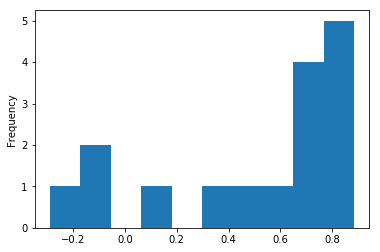

In [168]:
result_params["ar.L1"].plot.hist()

# Let's try forecasting

In [169]:
mean_params = result_params.mean()

In [170]:
hurricane_irene = data[data.name == "IRENE"]
hurricane_irene = hurricane_irene.set_index(pd.DatetimeIndex(hurricane_irene["timestamp"], freq="6H"))

In [171]:
hurricane_irene.tail()

,id,name,timestamp,status,latitude,longitude,wind_kt,min_pressure_mbar,sea_temp_degc,oni_flag
timestamp,,,,,,,,,,
2011-08-29 00:00:00,AL092011,IRENE,2011-08-29 00:00:00,EX,44.2,-72.1,45,979,NaN,-1
2011-08-29 06:00:00,AL092011,IRENE,2011-08-29 06:00:00,EX,46.5,-69.5,40,983,NaN,-1
2011-08-29 12:00:00,AL092011,IRENE,2011-08-29 12:00:00,EX,49.1,-66.7,40,985,11.97,-1
2011-08-29 18:00:00,AL092011,IRENE,2011-08-29 18:00:00,EX,51.3,-63.8,40,987,NaN,-1
2011-08-30 00:00:00,AL092011,IRENE,2011-08-30 00:00:00,EX,53.0,-60.0,40,991,NaN,-1


In [172]:
irene_mod = sm.tsa.statespace.SARIMAX(hurricane_irene['min_pressure_mbar'],
                                      # hurricane_irene[['latitude', 'longitude']],
                                      order=(1, 1, 1),
                                      seasonal_order=(2, 1, 0, 7),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

irene_results = irene_mod.filter(mean_params)

In [173]:
irene_prediction = irene_results.get_forecast(5)
irene_prediction

In [174]:
irene_prediction

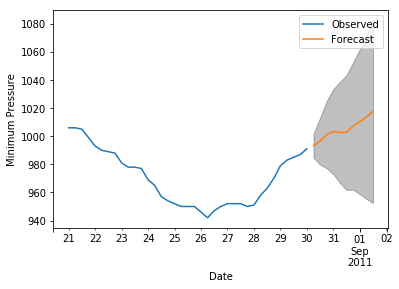

In [175]:
# Get forecast 5 steps ahead in future
irene_prediction = irene_results.get_forecast(steps=10)

# Get confidence intervals of forecasts
irene_prediction_ci = irene_prediction.conf_int()

ax = hurricane_irene['min_pressure_mbar'].plot(label='Observed')
irene_prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(irene_prediction_ci.index,
                irene_prediction_ci.iloc[:, 0],
                irene_prediction_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Minimum Pressure')

plt.legend()
plt.show()